In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from pylab import rcParams
import matplotlib.colors as colors

sns.set()

# Question 1: Propensity score matching

## 1. Naive analysis
*Compare the distribution of the outcome variable (re78) between the two groups, using plots and numbers. To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").*

*What might a naive "researcher" conclude from this superficial analysis?*

### Our solution
From this superficial analysis a naive researcher could state that *if any effect*, following the course actually seems to decrease your salary.

#### Procedure
To reproduce a naive analysis, we start by plotting the distribution of the salaries (`re78`) by treatment group. Then we try to find if there is any correlation between the treatment group and the salaries. Finally, we plot a bar chart of the mean of the salaries with error bars.

#### Implementation

In [2]:
# Load the dataset
data = pd.read_csv("lalonde.csv")
data.head(3)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.046
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.894
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.450


We plot the distribution of the salaries by treatment category

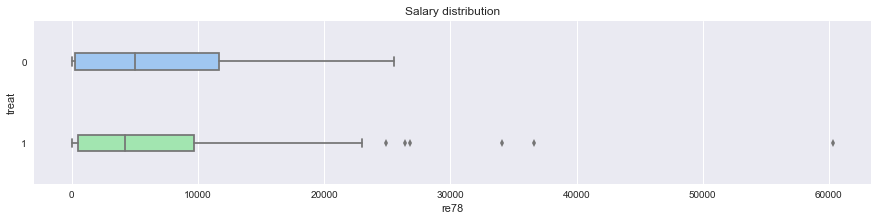

In [3]:
def salary_distribution(d, t=''):
    plt.figure(figsize=(15,3))
    sns.boxplot(x='re78', y='treat', data = d, width=0.2, palette='pastel', orient='h', showfliers=True).set_title(t)
    plt.show()
    
salary_distribution(data, "Salary distribution")

We continue by checking wether we find any correlation between the treatment category and the salaries.

In [4]:
data.corr().loc[('treat','re78')]

-0.039032705301538025

Due to the outliers, plotting mean and error results in uninterpretable plots.

[ 7294.16179087  7867.40221773]


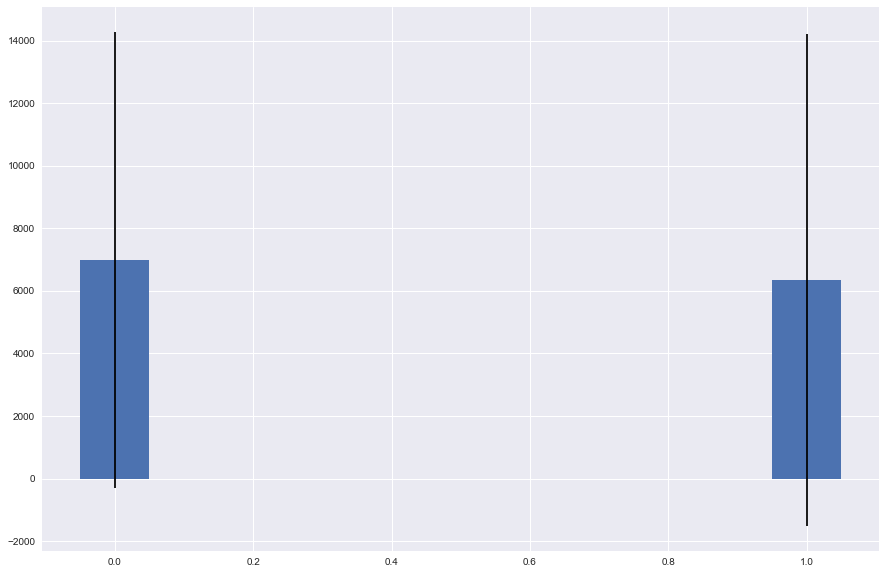

In [5]:
print(data[['treat','re78']].groupby('treat').std().values.squeeze())
plt.figure(figsize=(15,10))
plt.bar(range(2), 
        data[['treat','re78']].groupby('treat').mean().values.squeeze(), 
        yerr=data[['treat','re78']].groupby('treat').std().values.squeeze(), width=0.1)
plt.show()

## 2. A closer look at the data
*You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above. You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.*

*For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers. As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.*

*What do you observe? Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.*

### Our solution
We see that the input variables are distributed very unevenly between the treated and the untreated group. Especially regarding ethnicity. Indeed, people labelled as "black" make up over 80% of the treated group while only representing 20% of the control group. This observation also holds, to a smaller extent, for the distribution of hispanic and unmarried people. Moreover, salary distribution before the start of the observation is already very uneven, the non treated group having much higher salaries from the very beginning.
Finally, the range of values for the `age` and `years of education` is greater for the untreated group.

This means that the treated and control group are very dissimilar. This is evidence for confounding variables. For example, the course tend to be followed by people which have lower salaries and come from ethnic minorities. Therefore,  even if the course actually increased the salaries of those people, their increase in salary could very well be shadowed because they represent a much smaller portion of the control group.

#### Procedure:
Since `black`, `hispan`, `married`, and `nogedree` are indicator variables, we need to count them in order to better understand the underlying distribution. To have a full picture, we added an indicator variable `white` and set it to 1 whenever `black` or `hispan` were both zero. To determine if the group are balanced, we seek to find the ratio of each category of people in both the treated and the untreated group.

We continue by looking at the non-categorical input variables. This time, we use a mix between boxplots and violin plots to visualize their respective distribution. Violin plots usually combine a boxplot with a kernel density estimate of the underlying distribution. However, instead of directly using seaborn's violin plots with miniature boxplots in them, we chose to plot separately the violin and the box plot as is this more readable this way.

#### Implementation
We define a helper function `input_variable_analysis` that will be used throughout this notebook. It simply plots the different input variables.

Counts:


,black,hispan,married,nodegree,white,total
treat,,,,,,
0,87,61,220,256,281,429
1,156,11,35,131,18,185




Proportions of total


,black,hispan,married,nodegree,white
treat,,,,,
0,0.202797,0.142191,0.512821,0.596737,0.655012
1,0.843243,0.059459,0.189189,0.708108,0.097297


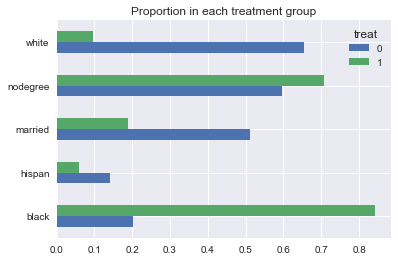

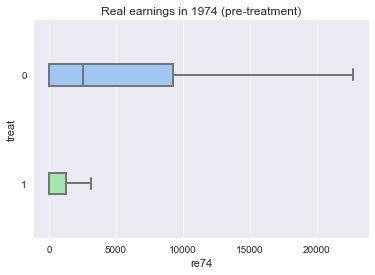

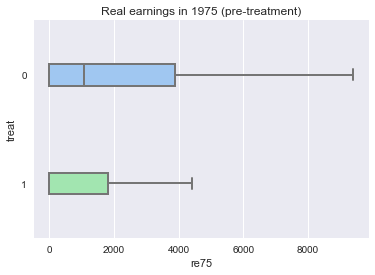

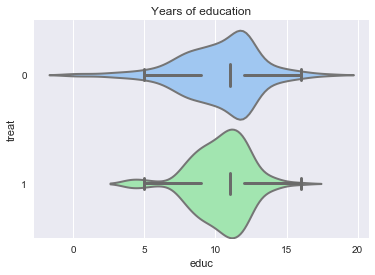

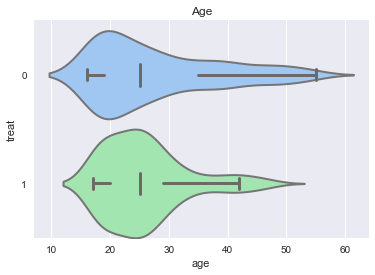

In [6]:
def input_variable_analysis(data):
    # Count the number of indicator variables in each category
    counts = data[['treat', 'black', 'hispan', 'married', 'nodegree']].groupby('treat').sum()
    counts['white'] = data.loc[(data['black']==0) & (data['hispan']==0)].groupby('treat').agg('count').black
    counts['total'] = data.groupby('treat').agg('count').black

    # Compute the proportion that each category represent amoung its respective treatment group
    proportions = counts[['black', 'hispan', 'married', 'nodegree', 'white']].div(counts.total, axis=0)

    print("Counts:")
    display(counts)
    print("\n\nProportions of total")
    display(proportions)
    
    # Plot proportion of each category
    proportions.transpose().plot.barh(title="Proportion in each treatment group")
    plt.show()

    # Plot a kernel density estimate and a boxplot for every non-categorical input variable
    sns.boxplot(x='re74', y='treat', data = data, width=0.2, linewidth=2, palette='pastel', showfliers=False, orient='h').set_title("Real earnings in 1974 (pre-treatment)")
    plt.show()
    sns.boxplot(x='re75', y='treat', data = data, width=0.2, linewidth=2, palette='pastel', showfliers=False, orient='h').set_title("Real earnings in 1975 (pre-treatment)")
    plt.show()
    sns.boxplot(x='educ', y='treat', data = data, width=0.2, linewidth=3, palette='Set3', showfliers=False, orient='h').set_title("Years of education")
    sns.violinplot(x='educ', y='treat', data = data, width=1, inner=None, linewidth=2, palette='pastel', orient='h').set_title("Years of education")
    plt.show()
    sns.boxplot(x='age', y='treat', data = data, width=0.2, linewidth=3, palette='Set3', showfliers=False, orient='h').set_title("Age")
    sns.violinplot(x='age', y='treat', data = data, width=1, inner=None, linewidth=2, palette='pastel', orient='h').set_title("Age")
    plt.show()
    
# Execute the function with the data we loaded previously
input_variable_analysis(data)

## 3. A propensity score model
*Use logistic regression to estimate propensity scores for all points in the dataset.*

### Our solution

#### Procedure
The input variables fed to the linear classifier are the variables pre-treatment. That is, `age`, `educ`, `black`, `hispan`, `married`, `nodegree`, `re74`, `re75`. The labels are given by the `treat` variable.

#### Implementation

We prepare the features matrix $X$ and the label vector $y$.

In [7]:
X = data[['age','educ','black','hispan','married','nodegree','re74','re75']].copy()
y = data['treat'].copy()

Then we fit the model to the data

In [8]:
from sklearn import linear_model
logistic = linear_model.LogisticRegression()

logistic.fit(X, y)
propensity_scores = logistic.predict_proba(X)[:, 1]
propensity_scores[:5]

array([ 0.44335042,  0.14465953,  0.72235463,  0.66415052,  0.69828561])

## 4. Balancing the dataset via matching
*Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group. (Hint: you may explore the networkx package in Python for predefined matching functions.)*

*Your matching should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.*

*After matching, you have as many treated as you have control subjects. Compare the outcomes (re78) between the two groups (treated and control).*

*Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects. What do you observe? Are you closer to being able to draw valid conclusions now than you were before?*

### Our solution
We can see that by matching we have a much better distribution of earnings pre-observation. Then, although not perfect, the ethnic groups are better balanced. We can already start spotting a different trend than in the naive analysis performed in section 1.1. Indeed, all the quartiles of the control group have shifted to the left, indicating lower salaries. However, the distribution of age and years of education remains mostly unchanged.

#### Procedure
To match pairs of subjects we build a graph where each subject is a node. Then, for each treated subject we add an edge  going to every control subject. We associate with this edge a weight $-w$ equal to the absolute difference between the propensity score of the treated and control subject. 

We run a maximum match algorithm on the graph built following the above description. Because the algorithm finds a match of maximum weight $w$, we effectively minimize the propensity score differences.

Finally, we call our helper function which plots the distributions of our input variables.

#### Implementation

In [9]:
import networkx as nx

We define a helper function which builds a bipartite graph given a dataset. The datasets consists of observations of the variables: `id`, `treat` and `propensity_score`.

In [10]:
def build_graph(data):
    """
    input: data, columns=[id, treat, propensity_score]
    output: a bipartite weighted graph with propensity scores as edge weight
    """
    treated = data[data.treat == 1]
    untreated = data[data.treat == 0]
    
    # Create empty graph
    G = nx.Graph()
    
    # Create a node for each data points
    G.add_nodes_from(data.id)
    
    # For each treated subject, add an edge to all untreated subjects.
    # Put the propensity score difference as the edge weight
    for i in range(treated.shape[0]):
        treated_subject = treated.iloc[i]
        print("Adding {} to the graph.".format(treated_subject.id), end='\r')
        for j in range(untreated.shape[0]):
            untreated_subject = untreated.iloc[j]

            # Use the negative of the difference as the weight since we want to minimize them over the matching
            prop_diff = -np.abs(treated_subject.propensity_score - untreated_subject.propensity_score)
            G.add_edge(treated_subject.id, untreated_subject.id, weight=prop_diff)
    
    return G
            

We apply the matching procedure to our data.

In [11]:
data_with_propensity = pd.concat([data[['id', 'treat']].copy(), pd.Series(propensity_scores, name='propensity_score')], axis=1)

G = build_graph(data_with_propensity)
print("The graph is bipartite: ", nx.is_bipartite(G))
print("Finding matches...")
matches = nx.max_weight_matching(G, maxcardinality=True)
print("Matches found")

The graph is bipartite:  True
Finding matches...
Matches found


We join the subjects using the dictionnary of maximum matches found above

In [12]:
matched_data = data_with_propensity[data_with_propensity.treat == 1].copy()

# Join matched subjects ids
matched_data['matched_subject'] = matched_data.id.map(matches)

# Join matched subject propensity score
matched_data['matched_propensity_score'] = matched_data.matched_subject.map(dict(zip(data_with_propensity.id,data_with_propensity.propensity_score)))

# Compute the propensity score differences
matched_data['difference'] = np.abs(matched_data.propensity_score - matched_data.matched_propensity_score)


Define a helper function which builds a dataset with the original format given pairs of matched subjects

In [13]:
def build_groups(matched_data_ids):
    treatment_balanced_group = matched_data_ids.merge(data, left_on='id', right_on='id', how='left')
    control_balanced_group = matched_data_ids.merge(data, left_on='matched_subject', right_on='id', how='left')

    treatment_balanced_group = treatment_balanced_group.drop(['id', 'matched_subject'], axis=1)
    control_balanced_group = control_balanced_group.drop(['id_x', 'matched_subject', 'id_y'], axis=1)
    
    return treatment_balanced_group, control_balanced_group

Recreate a more balanced dataset

In [14]:
matched_data_ids = matched_data[['id', 'matched_subject']].copy()

treatment_balanced_group, control_balanced_group = build_groups(matched_data_ids)

balanced_data = pd.concat([treatment_balanced_group, control_balanced_group])

Analyse the input variables once again:

Counts:


,black,hispan,married,nodegree,white,total
treat,,,,,,
0,87,22,31,116,76,185
1,156,11,35,131,18,185




Proportions of total


,black,hispan,married,nodegree,white
treat,,,,,
0,0.470270,0.118919,0.167568,0.627027,0.410811
1,0.843243,0.059459,0.189189,0.708108,0.097297


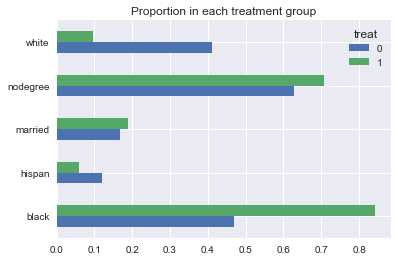

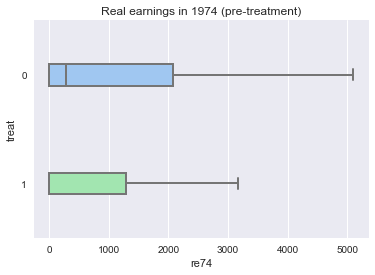

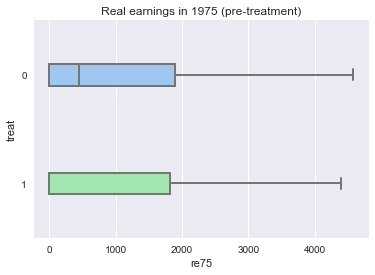

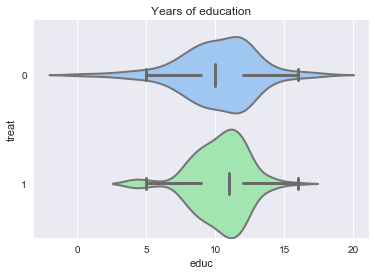

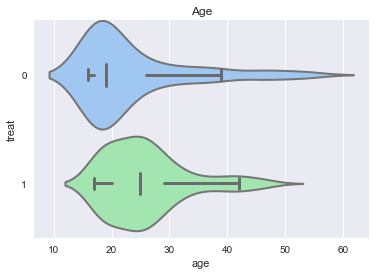

In [15]:
input_variable_analysis(balanced_data)

In [16]:
def compare_salary_distribution(d1, d2):
    salary_distribution(d1, 'Unbalanced data')
    salary_distribution(d2, 'Better balanced data')

Compare the salary distribution post-observation

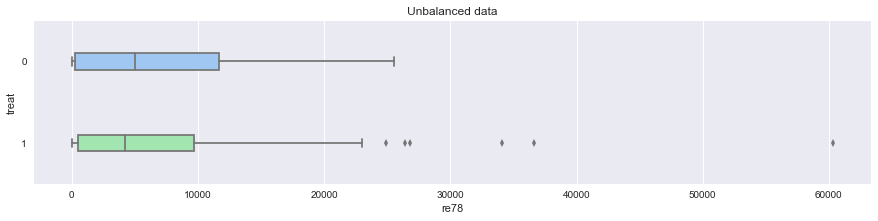

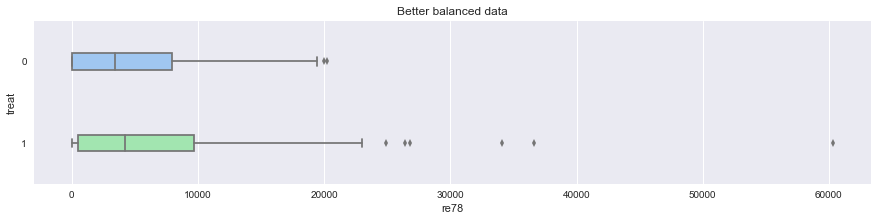

In [17]:
compare_salary_distribution(data, balanced_data)

## 5. Balancing the groups further
*Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching? Would you say your dataset is sufficiently balanced? If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?*

*Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature. Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.*
### Our solution
The matching can be further improved on the following points:
1. The ethnic group are still unbalanced
2. The age and years of education have different ranges

After following the procedure detailed below, we observe that the ethnic groups are much better balanced. We went from 47%/84% of `black` ratio in respectively the control and treatment group to 67%/68%. `white` went from 41%/10% to 26%/21%. The violin plot convinces us that the ages are also better balanced. Only the number of years of education remains difficult to balance as it is slightly bimodal in the treatment group.

#### Procedure
We start by removing from the matched pairs all the "bad pairs". That is, all the pairs for which the propensity score difference is higher than a fixed threshold. We chose this treshold to be 0.15 as not to throw away too much data.

Then, we try to limit the range of values for the  `age` such as to make them as similar as possible. One way to do this is to discard pairs whose age difference is higher that a fixed threshold. We fixed this threshold to be 8, again not to throw away to much data. The result is 57 matched pairs of similar distribution.

#### Implementation

In [18]:
# Keep only good matches
matched_data_cpy = matched_data.copy()
matched_data_cpy = matched_data_cpy[matched_data_cpy.difference < 0.15]
matched_data_ids = matched_data_cpy[['id', 'matched_subject']].copy()
treatment_balanced_group, control_balanced_group = build_groups(matched_data_ids)

In [19]:
balanced_data_sided = treatment_balanced_group.merge(control_balanced_group, left_index=True, right_index=True)

# Restrain the range of values for educ and age
balanced_data_sided = balanced_data_sided[(np.abs(balanced_data_sided.age_x - balanced_data_sided.age_y) < 8)]

print(balanced_data_sided.shape)

tmp1 = balanced_data_sided.iloc[:,0:10].copy()
tmp2 = balanced_data_sided.iloc[:, 10:].copy()
names = ['treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']
tmp1.columns = names
tmp2.columns = names

# Rebuild a balanced dataset
better_balanced_data = pd.concat([tmp1, tmp2], ignore_index=True, axis=0)

(59, 20)


Counts:


,black,hispan,married,nodegree,white,total
treat,,,,,,
0,40,5,11,37,14,59
1,41,6,10,36,12,59




Proportions of total


,black,hispan,married,nodegree,white
treat,,,,,
0,0.677966,0.084746,0.186441,0.627119,0.237288
1,0.694915,0.101695,0.169492,0.610169,0.203390


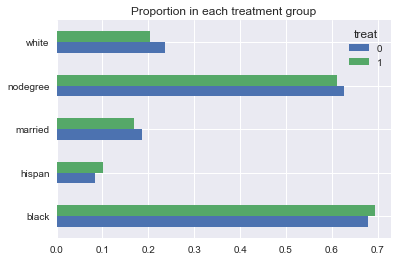

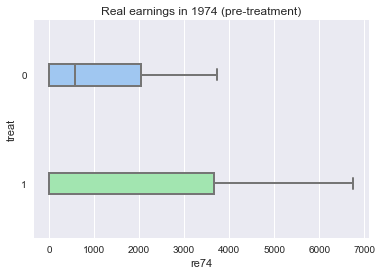

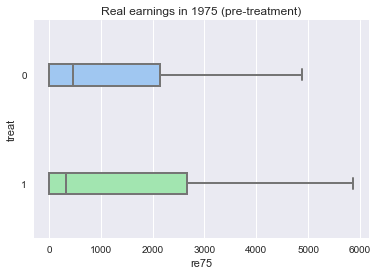

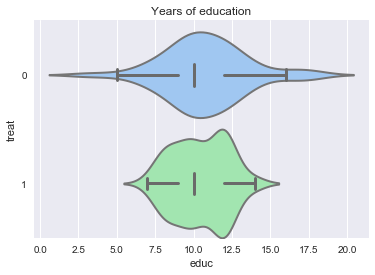

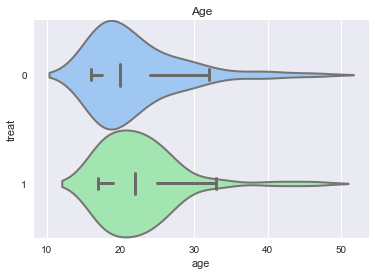

In [20]:
input_variable_analysis(better_balanced_data)

## 6. A less naive analysis
Compare the outcomes (re78) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5. What do you conclude about the effectiveness of the job training program?

### Our solution
As one may have expected, the training indeed seems to have a beneficial effect on the salaries of the people that followed it.

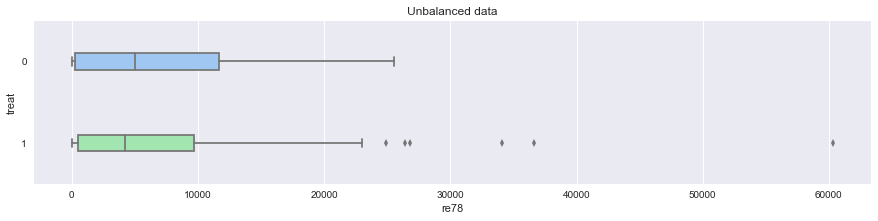

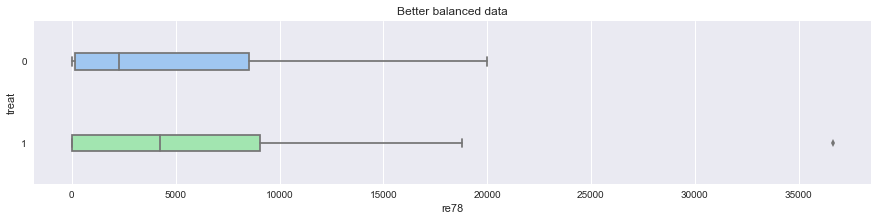

In [21]:
compare_salary_distribution(data, better_balanced_data)

# Question 2: Applied Machine Learning

First, we load the 20newsgroup dataset provided directly by sklearn.

In [22]:
newsgroups_train = fetch_20newsgroups()

After that, we compute TF-IDF features for every article using TfidfVectorizer. Then, we split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing) using the function *train_test_split* provided by sklearn.
We will make sure to filter the stopwords with a document frequency higher than 0.5.

In [23]:
# Vectorize the data in TF-IDF features
vectorizer = TfidfVectorizer(stop_words = 'english',sublinear_tf= True,max_df = 0.5)
x = vectorizer.fit_transform(newsgroups_train.data)
y = newsgroups_train.target
 
#Split the data
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print((X_validation).shape)
print((X_test).shape)
print((X_train).shape)

(1131, 129791)
(1132, 129791)
(9051, 129791)


Then, we train a random forest on our training set. We also tuned the parameters of your predictor on our validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth".

We came to the conclusion that the best max depth is 172 and the best number of estimators is 90.

In [24]:
# The hyperparamters to find with a grid search
tuned_parameters = {'max_depth': [10,50,90,120,150,172,175], 'n_estimators': [10,30,50,70,90]}
current_best_score = 0
best_max_depth = -1
best_n_estimators = -1

scores = []

for max_depth in tuned_parameters['max_depth']:
    for n_estimators in tuned_parameters['n_estimators']:
        clf = RandomForestClassifier(max_depth=max_depth, random_state=0,n_estimators = n_estimators)
        # Fit with the train data
        clf.fit(X_train, y_train)
        # Score with the validation data
        score = clf.score(X_validation,y_validation)
        
        scores.append(score)
        
        print("Score : {0} ; for max_depth = {1} and n_estimators = {2}".format(score,max_depth,n_estimators))
        if(score > current_best_score):
            current_best_score = score
            best_max_depth = max_depth
            best_n_estimators = n_estimators
            
print("\n \n The best score is: {0} ; for max_depth = {1} and n_estimators = {2}".format(current_best_score,best_max_depth,best_n_estimators))            

Score : 0.40318302387267907 ; for max_depth = 10 and n_estimators = 10
Score : 0.5755968169761273 ; for max_depth = 10 and n_estimators = 30
Score : 0.6578249336870027 ; for max_depth = 10 and n_estimators = 50
Score : 0.6905393457117595 ; for max_depth = 10 and n_estimators = 70
Score : 0.6949602122015915 ; for max_depth = 10 and n_estimators = 90
Score : 0.6799292661361627 ; for max_depth = 50 and n_estimators = 10
Score : 0.7913351016799293 ; for max_depth = 50 and n_estimators = 30
Score : 0.8249336870026526 ; for max_depth = 50 and n_estimators = 50
Score : 0.8311229000884174 ; for max_depth = 50 and n_estimators = 70
Score : 0.8408488063660478 ; for max_depth = 50 and n_estimators = 90
Score : 0.7276746242263483 ; for max_depth = 90 and n_estimators = 10
Score : 0.8107869142351901 ; for max_depth = 90 and n_estimators = 30
Score : 0.8381962864721485 ; for max_depth = 90 and n_estimators = 50
Score : 0.8532272325375774 ; for max_depth = 90 and n_estimators = 70
Score : 0.858532272

We will draw the different scores obtained.

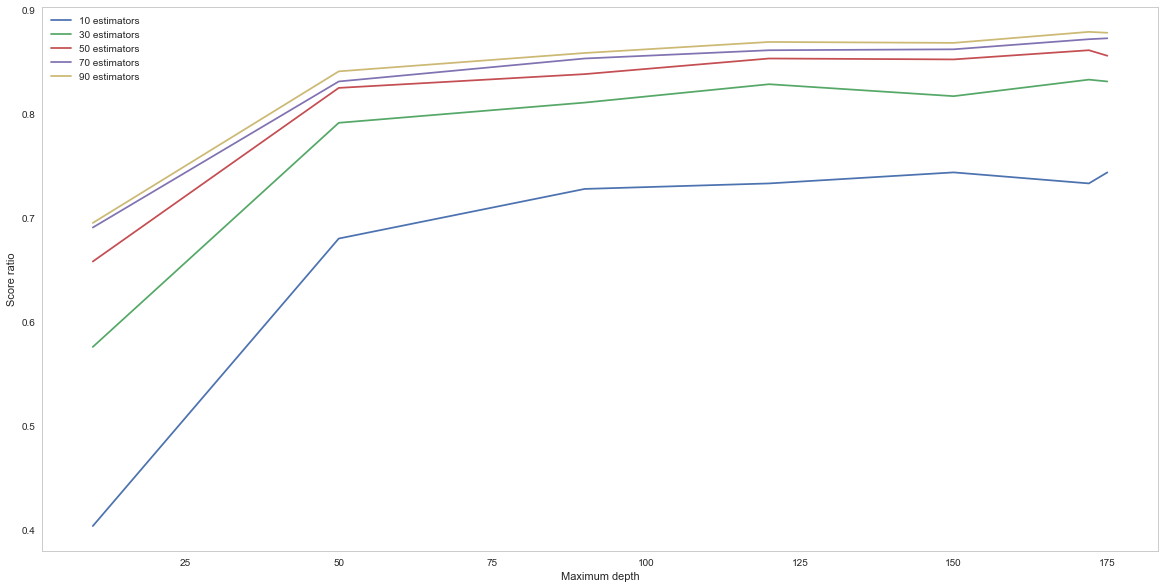

In [33]:
#Plot the various scores
sns.set_style("whitegrid", {'axes.grid' : False})
rcParams['figure.figsize'] = 20,10

scores = np.array(scores)
num_param_n_estimators= len(tuned_parameters['n_estimators'])
num_param_depth = len(tuned_parameters['max_depth'])

idx0 = [i*num_param_n_estimators for i in range(0,num_param_depth)]
idx1 = [i*num_param_n_estimators+1 for i in range(0,num_param_depth)]
idx2 = [i*num_param_n_estimators+2 for i in range(0,num_param_depth)]
idx3 = [i*num_param_n_estimators+3 for i in range(0,num_param_depth)]
idx4 = [i*num_param_n_estimators+4 for i in range(0,num_param_depth)]

plt.plot(tuned_parameters['max_depth'], scores[idx0], tuned_parameters['max_depth'], scores[idx1], \
         tuned_parameters['max_depth'], scores[idx2],tuned_parameters['max_depth'], scores[idx3], \
        tuned_parameters['max_depth'], scores[idx4])
plt.legend(["10 estimators","30 estimators","50 estimators", "70 estimators","90 estimators"])
plt.ylabel('Score ratio')
plt.xlabel('Maximum depth')
plt.show()

We then test our model on the test data.

In [34]:
# Test our model on the test data
clf = RandomForestClassifier(max_depth=best_max_depth, random_state=0,n_estimators = best_n_estimators)
clf.fit(X_train,y_train)
score = clf.score(X_test, y_test)

print("Test Score: ",score)

Test Score:  0.840106007067


After that, we display the confusion matrix of our classification pipeline.

In [35]:
#Print the confusion matrix
y_pred = clf.predict(X_test)
matrix = confusion_matrix(y_test,y_pred)

print(matrix)

[[48  1  0  0  0  0  0  0  0  0  0  0  0  1  0  2  0  0  3  3]
 [ 0 45  4  3  0  2  1  0  0  0  0  0  1  1  0  0  0  0  0  0]
 [ 0  3 47  5  0  2  1  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  5  5 38  3  0  4  1  0  0  0  0  1  0  0  2  0  0  0  0]
 [ 0  3  1  4 47  1  3  0  1  0  0  0  2  0  1  0  0  0  0  0]
 [ 0  1  1  1  0 45  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  1  1  2  0  0 46  2  0  0  0  0  1  1  0  0  0  0  0  0]
 [ 0  0  1  1  0  0  3 52  3  0  0  0  0  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  1 53  0  1  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 54  1  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 53  0  0  0  2  0  0  0  0  0]
 [ 0  1  1  0  0  1  0  0  0  0  0 66  0  0  0  0  0  0  0  0]
 [ 0  1  2  5  2  2  2  2  2  0  1  0 37  0  2  0  1  0  0  0]
 [ 0  1  0  0  0  0  1  0  0  0  1  0  1 49  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 66  1  0  0  0  0]
 [ 0  2  0  0  0  1  0  1  0  0  0  0  1  0  0 53  0  1

We now visualize the matrix. We see that as the diagonal contains mostly all the weight, this show that our model is pretty good. We see that there is some errors between related categories as expected; for example between hardware and graphics or between christian news and religion news.

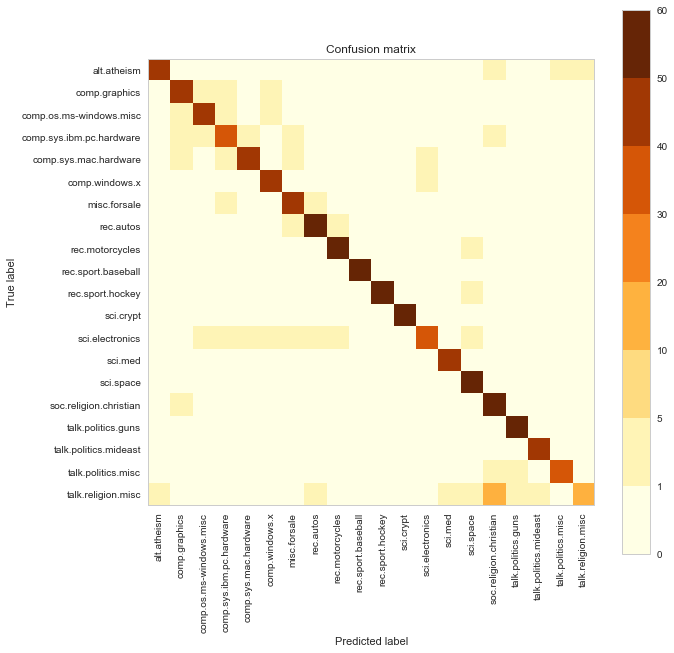

In [36]:
#Plot the confusion matrix
sns.set_style("whitegrid", {'axes.grid' : False})
rcParams['figure.figsize'] = 10,10

cmap= plt.cm.YlOrBr
title='Confusion matrix'
classes=list(newsgroups_train.target_names)

bounds=[0,1,5,10,20,30,40,50,60]
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.imshow(matrix, interpolation='nearest', cmap=cmap, norm = norm)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

We now analyze the different feature by sorting them by their importances.

In [37]:
feature_importances = clf.feature_importances_

In [38]:
words_index = list(vectorizer.vocabulary_.items())
words_index.sort(key = lambda x: x[1])
words = [x[0] for x in words_index]

In [39]:
#Create the new dataframe containing the moost important words.
df = pd.DataFrame.from_items([('Importance',feature_importances),('Words',words)])
df = df.sort_values("Importance",ascending = False).reset_index()
df.head(20)

,index,Importance,Words
0,104203,0.006258,sale
1,124129,0.005313,windows
2,48354,0.004659,dod
3,37722,0.004186,car
4,63512,0.004122,hockey
5,59516,0.004020,god
6,33252,0.003907,bike
7,108831,0.003627,space
8,78439,0.003025,mac
9,40388,0.003013,clipper


We will analyze each word, by regrouping them as much as we can in categories:
* First, we can see that the second most important word is windows, it's understandable as it's the most popular OS on laptop of the world (52.2% of total laptops); a lot of computer oriented news groups should talk frequently about it. At the 9th place there is mac. We can also see that encryption(11th) and graphics(15th) are very important, this is easily explainable by the fact that those sectors have constantly new discoveries.
* Then, on the political category, we see that Israeli is 13th (and Israel 16th) and dod third. As Israel is always a hot topic it's normal to see it in the top places. The dod( United States Department of Defense) is at the 3rd place as a lot of news of current war, terrorism could be directly announced by it.
* Then on the sport category, we see that the car, bike, hockey, nhl and baseball are the most important sports in the news group that we have.
* On the economic(for sale) category, we see that the most important word is sale. We also have shipping (18th) and offer (20th). 
* On the religious category, we see that god is quite important (6th), as well as christian (19th).
* Finally, we have some unclassifiable terms like space(8th); as this is an important topic, it's not a surprise to see it there.

We also displayed the first few words by importance to see more visually the distribution:

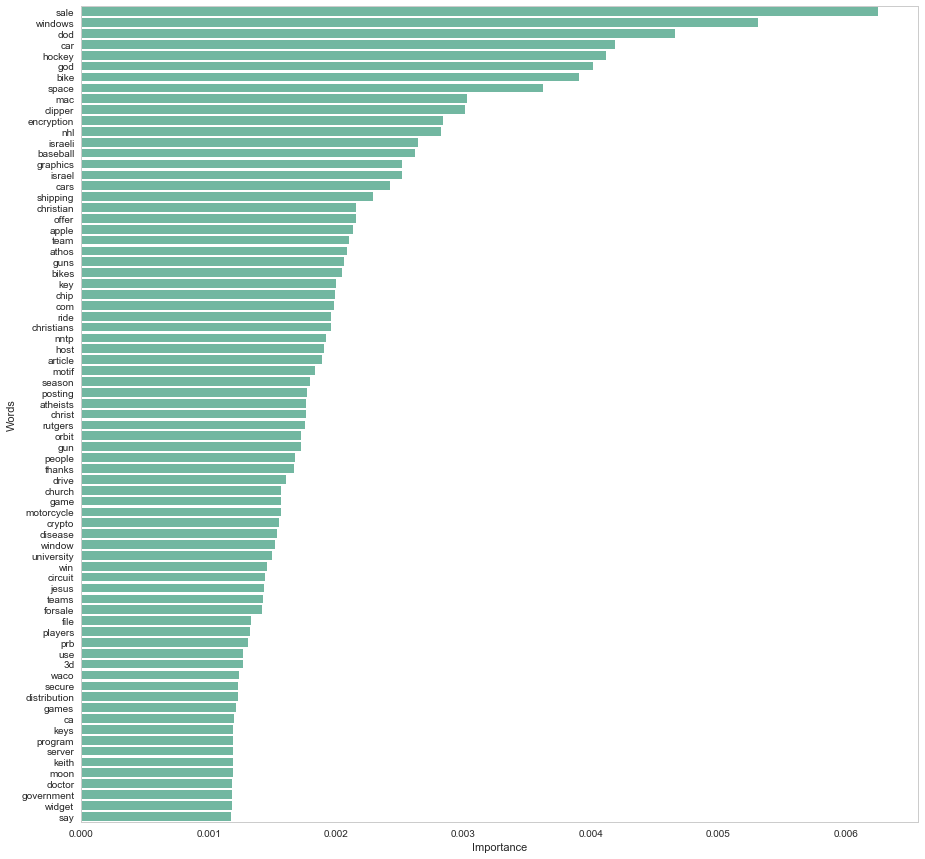

In [40]:
rcParams['figure.figsize'] = 15, 15
df2 = df[['Importance','Words']].head(75)
sns.barplot(y="Words",x='Importance', orient='h', data=df2,palette = sns.color_palette("BuGn_r", 1));
plt.show()